# A conditional GAN with Tensorflow <a class="tocSkip">

[Tomas Beuzen](https://tomasbeuzen.github.io/) (May 2020)
    
---    

# Introduction

This notebook walks through a simple implementation of a conditional GAN on the mnist digits dataset.

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 16,
                     'axes.labelweight': 'bold',
                     'figure.figsize': (8,6)})

# A conditional GAN

In the [GAN notebook](GAN.ipynb), we were only looking at a single class (the digit 0). We could have included all of the data if we wanted to and then generated random digits from the latent space, but it would probably be more helpful if we could choose what digits we wanted to generate - enter, conditional GANs.

The code to implement a conditional GAN is a little more involved. I'm going to leverage an example from [machinelearningmastery.com](https://machinelearningmastery.com/how-to-develop-a-conditional-generative-adversarial-network-from-scratch/) for the implementation below. The idea is to include the class labels as inputs to the model now.

## Models

### Generator

In [3]:
# define the standalone generator model
def define_generator(latent_dim, n_classes=10):
    # label input
    in_label = layers.Input(shape=(1,))
    # embedding for categorical input
    li = layers.Embedding(n_classes, 50)(in_label)
    # linear multiplication
    n_nodes = 7 * 7
    li = layers.Dense(n_nodes)(li)
    # reshape to additional channel
    li = layers.Reshape((7, 7, 1))(li)
    # image generator input
    in_lat = layers.Input(shape=(latent_dim,))
    # foundation for 7x7 image
    n_nodes = 128 * 7 * 7
    gen = layers.Dense(n_nodes)(in_lat)
    gen = layers.LeakyReLU(alpha=0.2)(gen)
    gen = layers.Reshape((7, 7, 128))(gen)
    # merge image gen and label input
    merge = layers.Concatenate()([gen, li])
    # upsample to 14x14
    gen = layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(merge)
    gen = layers.LeakyReLU(alpha=0.2)(gen)
    # upsample to 28x28
    gen = layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
    gen = layers.LeakyReLU(alpha=0.2)(gen)
    # output
    out_layer = layers.Conv2D(1, (7,7), activation='tanh', padding='same')(gen)
    # define model
    model = tf.keras.models.Model([in_lat, in_label], out_layer)
    return model

### Discriminator

In [4]:
# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1), n_classes=10):
    # label input
    in_label = layers.Input(shape=(1,))
    # embedding for categorical input
    li = layers.Embedding(n_classes, 50)(in_label)
    # scale up to image dimensions with linear activation
    n_nodes = in_shape[0] * in_shape[1]
    li = layers.Dense(n_nodes)(li)
    # reshape to additional channel
    li = layers.Reshape((in_shape[0], in_shape[1], 1))(li)
    # image input
    in_image = layers.Input(shape=in_shape)
    # concat label as a channel
    merge = layers.Concatenate()([in_image, li])
    # downsample
    fe = layers.Conv2D(128, (3,3), strides=(2,2), padding='same')(merge)
    fe = layers.LeakyReLU(alpha=0.2)(fe)
    # downsample
    fe = layers.Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
    fe = layers.LeakyReLU(alpha=0.2)(fe)
    # flatten feature maps
    fe = layers.Flatten()(fe)
    # dropout
    fe = layers.Dropout(0.4)(fe)
    # output
    out_layer = layers.Dense(1, activation='sigmoid')(fe)
    # define model
    model = tf.keras.models.Model([in_image, in_label], out_layer)
    # compile model
    opt = tf.keras.optimizers.Adam(lr=0.0001, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

### GAN

In [5]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # get noise and label inputs from generator model
    gen_noise, gen_label = g_model.input
    # get image output from the generator model
    gen_output = g_model.output
    # connect image output and label input from generator as inputs to discriminator
    gan_output = d_model([gen_output, gen_label])
    # define gan model as taking noise and label and outputting a classification
    model = tf.keras.models.Model([gen_noise, gen_label], gan_output)
    # compile model
    opt = tf.keras.optimizers.Adam(lr=0.0001, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

## Train the model

In [6]:
# size of the latent space (usually 100)
latent_dim = 100

In [8]:
# load fashion mnist images
def load_real_samples():
    # load dataset
    (trainX, trainy), (_, _) = tf.keras.datasets.mnist.load_data()
    # expand to 3d, e.g. add channels
    X = tf.expand_dims(trainX, axis=-1)
    # convert from ints to floats
    X = tf.cast(X, tf.float32)
    # scale from [0,255] to [-1,1]
    X = (X - 127.5) / 127.5
    return [X, trainy]
 
# # select real samples
def generate_real_samples(dataset, n_samples):
    # split into images and labels
    images, labels = dataset
    # choose random instances
    ix = np.random.randint(0, images.shape[0], n_samples)
    # select images and labels
    X, labels = images.numpy()[ix], labels[ix]
    # generate class labels
    y = tf.ones((n_samples, 1))
    return [X, labels], y
 
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
    # generate points in the latent space
    x_input = np.random.randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    # generate labels
    labels = np.random.randint(0, n_classes, n_samples)
    return [z_input, labels]
 
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
    # generate points in latent space
    z_input, labels_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    images = generator.predict([z_input, labels_input])
    # create class labels
    y = tf.zeros((n_samples, 1))
    return [images, labels_input], y
 
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
    bat_per_epo = int(dataset[0].shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        print(f"On epoch {i + 1}")
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            # get randomly selected 'real' samples
            [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
            # update discriminator model weights
            d_loss1, _ = d_model.train_on_batch([X_real, labels_real], y_real)
            # generate 'fake' examples
            [X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # update discriminator model weights
            d_loss2, _ = d_model.train_on_batch([X_fake, labels], y_fake)
            # prepare points in latent space as input for the generator
            [z_input, labels_input] = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = tf.ones((n_batch, 1))
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
            # summarize loss on this batch
            if j % 100 == 0:
                print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
                    (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
    # save the generator model
#     g_model.save('saved_models/GAN_cgan_generator.h5')

In [9]:
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
# train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=3)
# load model
model = tf.keras.models.load_model('saved_models/GAN_cgan_generator.h5')

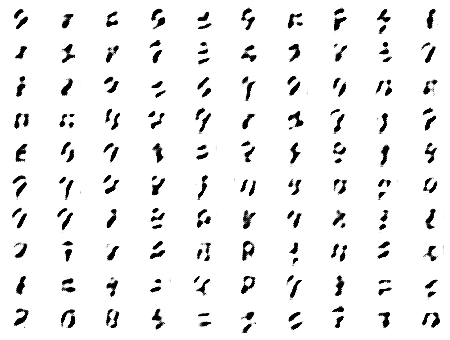

In [10]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
    # generate points in the latent space
    x_input = np.random.randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    # generate labels
    labels = np.random.randint(0, n_classes, n_samples)
    return [z_input, labels]
 
# create and save a plot of generated images
def create_plot(examples, n):
    # plot images
    for i in range(n * n):
        # define subplot
        plt.subplot(n, n, 1 + i)
        # turn off axis
        plt.axis('off')
        # plot raw pixel data
        plt.imshow(examples[i, :, :, 0], cmap='gray_r')
    plt.show()

# generate images
latent_points, labels = generate_latent_points(100, 100)
# specify labels
labels = np.asarray([x for _ in range(10) for x in range(10)])
# generate images
X  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
create_plot(X, 10)